In [1]:
!pip install -U linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.5 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: formulaic
    Found existing installation: formulaic 1.1.1
    Uninstalling formulaic-1.1.1:
      Successfully uninstalled formulaic-1.1.1
  Attempting uninstall: linearmodels━━━━━━━━━━━━ 0/2 [formulaic]
    Found existing installation: linearmodels 6.10/2 [formulaic]
    Uninstalling linearmodels-6.1:━━━━━━━━━━ 0/2 [formulaic]
      Successfully uninstalled linearmodels-6.1m 0/2 [formulaic]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [linearmodels] [linearmodels]


In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=CSV%20format

## Life table

* mx: Central death rate, nmx, for the age interval (x, x+n)
* qx: Probability of dying (nqx), for an individual between age x and x+n
* px: Probability of surviving, (npx), for an individual of age x to age x+n
* lx: Number of survivors, (lx), at age (x) for 100000 births
* dx: Number of deaths, (ndx), between ages x and x+n
* Lx: Number of person-years lived, (nLx), between ages x and x+n
* Sx: Survival ratio (nSx) corresponding to proportion of the life table population in age group (x, x+n) who are alive n year later
* Tx: Person-years lived, (Tx), above age x
* ex: Expectation of life (ex) at age x, i.e., average number of years lived subsequent to age x by those reaching age x
* ax: Average number of years lived (nax) between ages x and x+n by those dying in the interval

# Life expectancy

In [2]:
df = pd.read_csv("data/WPP2024_Life_Table_Abridged_Medium_1950-2023.csv")
df.head()

/var/folders/50/qly_r7y17754hf5lyq92cnjh0000gn/T/ipykernel_76898/433068357.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/WPP2024_Life_Table_Abridged_Medium_1950-2023.csv")


,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,...,mx,qx,px,lx,dx,Lx,Sx,Tx,ex,ax
0,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,0.255920,0.218190,0.781810,100000.000,21819.033,85257.099,0.732072,3810819.176,38.1082,0.324310
1,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,0.041708,0.149792,0.850208,78180.967,11710.848,280778.889,0.893831,3725562.078,47.6531,1.272189
2,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,0.005242,0.025803,0.974197,66470.119,1715.153,327174.187,0.981530,3444783.189,51.8245,1.981956
3,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,0.003432,0.017018,0.982982,64754.966,1101.997,321131.394,0.979629,3117609.002,48.1447,2.601234
4,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,0.004973,0.024577,0.975423,63652.968,1564.391,314589.479,0.970460,2796477.608,43.9332,2.650612


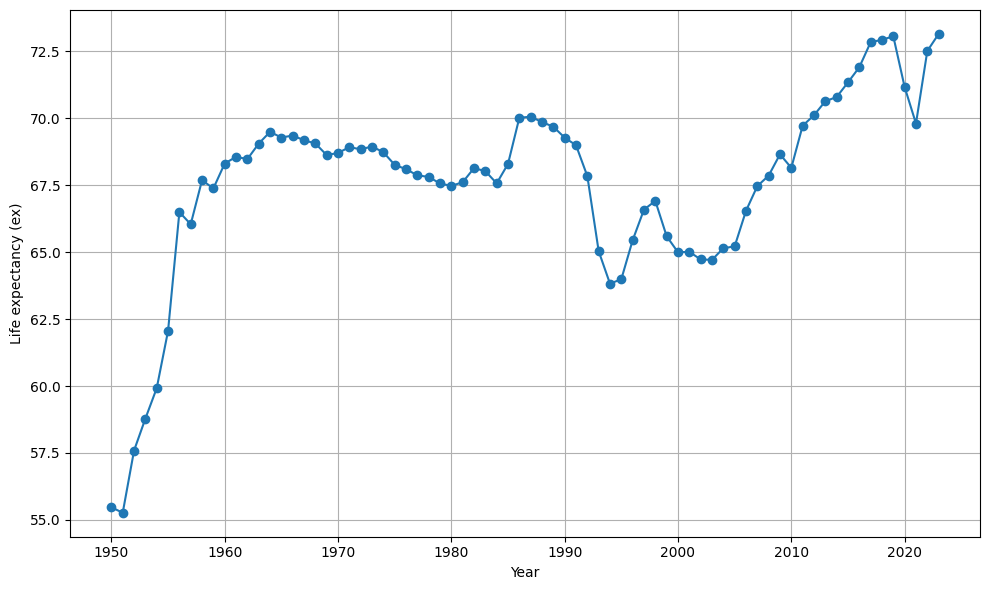

In [5]:
df_ex = df[
    (df["ISO3_code"] == "RUS") &
    (df['Sex'] == 'Total') &
    ((df['AgeGrpStart'] == 0) | (df['AgeGrp'] == '0-1'))
]

df_ex = df_ex.sort_values('Time')

years = df_ex['Time']
life_expectancy = df_ex['ex']


plt.figure(figsize=(10,6))
plt.plot(years, life_expectancy, marker='o')
plt.xlabel('Year')
plt.ylabel('Life expectancy (ex)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Life expectancy calculation

- Step 1: The Death Rate ($m_{x}$) is the foundation of all calculations
- Step 2: Probability of Dying ($q_{x}$) - Converting Intensity to Probability
- Step 3: The probability of survival ($p_{x}$) is an optimistic indicator
- Step 4: Number of survivors ($l_{x}$) - The fate of the conditional generation
- Step 5: Number of Deaths ($d_{x}$) - Death Distribution
- Step 6: Man-years lived ($L_{x}$) - Life time accounting
- Step 7: Total Man-years ($T_{x}$) - Remaining life span
- Step 8: Life Expectancy ($e_{x}$)

In [16]:
# For 2023
df_ex = df_ex[df_ex["Time"] == 2023]

In [17]:
# mortality rate in the age range
mx = df_ex['mx']

### Calculate $q_{x}$ (the probability of dying in the age range) from $m_{x}$

$q_x = \frac{n \cdot m_x}{1 + (n - a_x) \cdot m_x}$

where

$n$ - length of the age interval

$a_x$ - average number of person-years lived in the interval by those who died in that interval

However, $a_x$ is usually difficult to calculate, and approximations are often used. In demography, for ages 5 years and above, $a_x = n/2$ is commonly used.

For infants (age 0), $a_x$ is typically taken as approximately 0.1-0.3, and for ages 1-4 years - approximately 1.5.

However, in our case, to avoid complicating matters, we can use simplified formulas if we do not know $a_x$. However, the data already contains $a_x$, but according to the conditions, we should not use them. Therefore, we will use standard approximations for $a_x$.

Standard approximations for $a_x$ (from UN methodology):

For age 0: $(a_{0} = 0.1 + 1.5 \cdot m_{0})$ (if the infant mortality rate is high, it may be 0.3, but we have data, so we could try to calculate from the available data, but we cannot use pre-calculated $a_{x}$, so we use the approximation)

For ages 1-4: ($a_{1}$ = 1.5)

For ages 5-9, 10-14, ...: ($a_{x}$ = 2.5) (when $n=5$)

However, to be precise, we could calculate $a_x$ from the available data, but this is complex. Therefore, we will use standard approximations.

In [ ]:
import numpy as np


def calculate_qx(df: pd.DataFrame):

    """Calculates probability of dying"""
    conditions = [
        df['AgeGrpStart'] == 0,  # infant
        df['AgeGrpSpan'] == 1,   # one-year
        df['AgeGrpSpan'] > 1     # others
    ]
    choices = [
        # <YOUR CODE>,  # for a_0
        # <YOUR CODE>, # for a_1,
        # <YOUR CODE>, for others
    ]
    
    return np.select(conditions, choices)

df_ex['qx_calc'] = calculate_qx(df_ex)

In [ ]:
# Probability of survival (px)
# px = 1 - qx
# <YOUR CODE>

In [ ]:
# Number of survivors (lx)

# lx = lx_previous * px_previous for each cohort (start cohort = 100000)


def calculate_lx(df: pd.DataFrame):
    lx_values = [100000]
    
    for i in range(1, len(df)):
        # <YOUR CODE>
    
    return lx_values



In [12]:
# Number of people dying (dx)
# dx = lx * qx
df_ex['dx_calc'] = ...

### Person-years lived

Let's break it down:

* $n × (l_{x} - d_{x})$ — years lived by those who survived the interval (they lived the entire interval)
* $a_{x} × d_{x}$ — years lived by those who died during the interval (they lived only part of the interval)

In [ ]:
# Person-years lived (Lx)

def calculate_Lx(df: pd.DataFrame):
    Lx_values = []
    
    for i, row in df.iterrows():
        if row['AgeGrpSpan'] > 0:
            # <YOUR CODE>
        else:
            Lx = row['lx_calc'] / row['mx'] if row['mx'] > 0 else 0
        Lx_values.append(Lx)
    
    return Lx_values

df_ex["Lx_calc"] = calculate_Lx(df_ex)


In [ ]:
# Total man-years
# Tx = sum(Lx_from_current_to_end)
# <YOUR CODE>
df_ex['Tx_calc'] = ...

In [ ]:
# Life expectancy (ex)

df_ex['ex_calc'] = df_ex['Tx_calc'] / df_ex['lx_calc']

In [ ]:
df_example = df[
    (df["ISO3_code"] == "RUS") &
    (df['Sex'] == 'Total') &
    (df["Time"] == 2023)
]


df_example['qx_calc'] = calculate_qx(df_example)
df_example['px_calc'] = 1 - df_example['qx_calc']
df_example['lx_calc'] = calculate_lx(df_example)
df_example['dx_calc'] = df_example['lx_calc'] * df_example['qx_calc']
df_example['Lx_calc'] = calculate_Lx(df_example)
df_example['Tx_calc'] = df_example['Lx_calc'][::-1].cumsum()[::-1]
df_example['ex_calc'] = df_example['Tx_calc'] / df_example['lx_calc']

print("Comparison of calculated and initial values of ex:")
print(f"e0 calculated: {df_example['ex_calc'].iloc[0]:.2f}")
print(f"e0 initial: {df_example['ex'].iloc[0]:.2f}")

In [ ]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Survival curve
# <YOUR CODE>
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('lx (people, thousands)')
axes[0,0].set_title('Survival curve')
axes[0,0].grid(True, alpha=0.3)

# Survival function
# <YOUR CODE>
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Life expectancy')
axes[0,1].set_title('Life expectancy by age')
axes[0,1].grid(True, alpha=0.3)

# 3. Distribution of deaths (dx)
# <YOUR CODE>
axes[1,0].set_xlabel('Agy')
axes[1,0].set_ylabel('dx (death in thousands)')
axes[1,0].set_title('Distribution of deaths by age')
axes[1,0].grid(True, alpha=0.3)

# 4. Comparison of calculated and initial values of ex
# <YOUR CODE>
axes[1,1].plot(df_example['AgeGrpStart'], df_example['ex'], label='Initial', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('ex')
axes[1,1].set_title('Comparison of calculated and initial values of ex')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Median age at death is the age at which 50% of the cohort remains
# <YOUR CODE>
print(f"Median age at death: {median_death_age} years")

plt.figure(figsize=(10, 6))
# <YOUR CODE>
plt.axhline(y=50000, color='red', linestyle='--', alpha=0.7, label='50% of the cohort')
plt.axvline(x=median_death_age, color='green', linestyle='--', alpha=0.7, label=f'Median death age: {median_death_age} years')
plt.xlabel('Age')
plt.ylabel('lx (number of survivors)')
plt.title('Median age at death')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Death rate

In [19]:
death = pd.read_csv("data/WPP2024_DeathsBySingleAgeSex_Medium_1950-2023.csv")
death.head()

/var/folders/50/qly_r7y17754hf5lyq92cnjh0000gn/T/ipykernel_76898/2950225642.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  death = pd.read_csv("data/WPP2024_DeathsBySingleAgeSex_Medium_1950-2023.csv")


,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,DeathMale,DeathFemale,DeathTotal
0,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,2,Medium,1950,1950.5,0,0,1,324.189,275.913,600.102
1,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,2,Medium,1950,1950.5,1,1,1,88.236,80.553,168.789
2,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,2,Medium,1950,1950.5,2,2,1,43.582,43.471,87.053
3,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,2,Medium,1950,1950.5,3,3,1,22.927,24.568,47.495
4,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,2,Medium,1950,1950.5,4,4,1,12.660,14.453,27.113


## Death rate table description

* SortOrder is the sequential number of the record (probably for sorting).
* LocID is the identifier of the location (country or region). Here 380 is the Italian code.
* Notes - notes (missing from the data).
* ISO3_code is a three-letter country code (ITA - Italy).
* ISO2_code is a two-letter country code (IT is Italy).
* SDMX_code is the code in the SDMX (Statistical Data and Metadata Exchange) format (380.0).
* LocTypeID is the type of location (4.0 is the country/territory).
* LocTypeName - the name of the location type (Country/Area).
* ParentID is the identifier of the parent location (925.0 is probably the area code of Italy).
* Location - the name of the location (Italy).
* VarID is the identifier of the variant (2 is probably the average forecast variant).
* Variant is the name of the variant (Medium is the average variant).
* Time is the year (1950, 1951, ... 2023).
* MidPeriod is the middle of the period (1950.5 - mid-1950).
* AgeGrp - age group code (0, 1, 2, ... 100+).
* AgeGrpStart - the beginning of the age range (0, 1, 2, ... 100).
* AgeGrpSpan is the length of the age range (1 year, except for the last group of 100+, where -1 stands, which probably means an open interval).
* DeathMale is the number of deaths of men (in thousands) in a given age group per year.
* DeathFemale is the number of deaths of women (in thousands) in a given age group per year.
* DeathTotal is the total number of deaths (in thousands) in a given age group per year.

In [20]:
death_it = death[death["ISO3_code"] == "ITA"]
death_it.head()

,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,DeathMale,DeathFemale,DeathTotal
3333404,218.0,380,NaN,ITA,IT,380.0,4.0,Country/Area,925.0,Italy,2,Medium,1950,1950.5,0,0,1,32.079,26.366,58.445
3333405,218.0,380,NaN,ITA,IT,380.0,4.0,Country/Area,925.0,Italy,2,Medium,1950,1950.5,1,1,1,5.087,4.929,10.016
3333406,218.0,380,NaN,ITA,IT,380.0,4.0,Country/Area,925.0,Italy,2,Medium,1950,1950.5,2,2,1,1.840,1.600,3.440
3333407,218.0,380,NaN,ITA,IT,380.0,4.0,Country/Area,925.0,Italy,2,Medium,1950,1950.5,3,3,1,1.076,0.921,1.997
3333408,218.0,380,NaN,ITA,IT,380.0,4.0,Country/Area,925.0,Italy,2,Medium,1950,1950.5,4,4,1,0.661,0.630,1.291


In [ ]:
# Total mortality by year
# <YOUR CODE>

plt.figure(figsize=(12, 6))
# plt.plot(<YOUR CODE>, marker='o')
plt.title('Total mortality by year')
plt.xlabel('Year')
plt.ylabel('Amount of death (thousands)')
plt.grid(True)
plt.show()

In [ ]:
# infant mortality (age = 0)
# <YOUR CODE>

plt.figure(figsize=(10, 6))
# plt.plot(<YOUR CODE>, <YOUR CODE>, marker='o', label='Total')
# plt.plot(<YOUR CODE>, <YOUR CODE>, marker='s', label='Male')
# plt.plot(<YOUR CODE>, <YOUR CODE>, marker='^', label='Female')
plt.title('Infant Mortaility')
plt.xlabel('Year')
plt.ylabel('Death')
plt.legend()
plt.grid(True)
plt.show()

# Linear regression


## Analysis of the influence of demographic indicators on mortality

### Formulation

* The aim of the study is to identify the **influence of previous values of demographic characteristics on the current mortality rate**, taking into account the specific features of each location.

* Hypothesis:

### Cohort Aging Effect
Past demographic indicators, reflecting population structure and reproduction, predict current mortality through the mechanism of cohort aging. Generations with low survival probabilities in the past are reaching older ages today, leading to an increase in the absolute number of deaths

### Health & Development Persistence
Past life expectancy reflects the quality of healthcare, level of development, and socioeconomic conditions of a location, which remain **relatively stable over time**. Locations with high life expectancy 5-15 years ago have better conditions, leading to **low current mortality**, even taking into account population aging.


## Assumptions

1. **Location fixed effects** -- each location has a **unique constant mortality rate**, determined by its geographic, medical, and social characteristics (climate, level of healthcare, genetic characteristics), which do not change over time.

2. **Strict exogeneity** -- lagged demographic indicators are uncorrelated with the model's errors. Assumption: past demographic characteristics influence mortality, but current mortality does not influence past indicators (logically, in the time direction).

3. **Linear dependence** -- the relationship between the features and the target is linear after taking into account lags.


In [21]:
target = "DeathTotal"
features = ["dx", "lx", "Lx", "Sx", "ex", "ax"]
time_column = "Time"
index_column = "Location"

## Join datasets

In [ ]:
list1 = df.columns.tolist()
list2 = death.columns.tolist()
common_columns = [col for col in list1 if col in list2]
df_lin_reg = pd.merge(df, death, on=common_columns, how="inner")
print(df_lin_reg.shape)
df_lin_reg.head()

## Data Cleaning

In [ ]:
# Delete null observations
df_lin_reg = # <YOUR CODE>
df_lin_reg.shape

In [ ]:
# Delete duplicates from data
df_lin_reg = # <YOUR CODE>
print(df_lin_reg.shape)

# EDA

In [ ]:
import seaborn as sns
# pairplot
# <YOUR CODE>

In [ ]:
# correlation matrix
# <YOUR CODE>

### Feature Engineering

In [ ]:
def generate_lag_features(df, features, time_col, group_col, lags):
    df = df.sort_values([group_col, time_col]).copy()
    cols = []
    for feature in features:
        for lag in lags:
            lagged_col_name = f'{feature}_lag_{lag}'
            # <YOUR CODE>
            cols.append(lagged_col_name)
    return df, cols

# Использование:
lags = [5, 10, 15]
df_new, new_features = generate_lag_features(df_lin_reg, features, time_column, index_column, lags)
df_new = df_new.dropna(subset=new_features)

In [ ]:
## Delete high correlated features

def remove_correlated_features(df, features, corr_threshold=0.9):
    # corr_matrix = <YOUR CODE>
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # to_drop = <YOUR CODE>
    return [f for f in features if f not in to_drop]


# Model

In [ ]:
# OLS

import statsmodels.api as sm

Y = df_new[target]
X = df_new[new_features_3]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

results.summary()

In [ ]:
# Fixed Effects
from linearmodels.panel import PanelOLS

df_new_panel = df_new.set_index(['Location', 'Time'])
y = df_new_panel['DeathTotal']
X = df_new_panel[new_features]

X = sm.add_constant(X)

model = PanelOLS(y, X, entity_effects=True)
results = model.fit()

results.summary
